# Using PySynphot

*Authors: Deepashri Thatte, Varun Bajaj, Tyler Desjardins*<br>
Version 2.0 June 19, 2018

## Introduction

[Astrolib PySynphot](http://pysynphot.readthedocs.io/) (hereafter referred to as `pysynphot`) is a Python package and an object oriented replacement for STSDAS SYNPHOT synthetic photometry package in IRAF. `pysynphot` simulates photometric data and spectra as they are observed with the *Hubble Space Telescope* (*HST*). It allows for much easier integration with other Python code when compared to using Synphot via PyRAF. It can also be used for the *James Webb Space Telescope* (*JWST*) with users' own data files (e.g. filter throughputs) and reference data. The current distribution of Pysynphot does not support JWST observing modes in a similar manner as HST because the necessary *JWST* data files are not yet available for public distribution.

This tutorial will cover the basics of using `pysynphot` to create spectra, bandpasses, and synthetic observations for both *HST* and *JWST* instruments. You will encounter a few exercises in this training, please save your plots and record you answers so your trainer(s) can review them.

**For trainees:** In the follow examples, we frequently use `matplotlib` to make plots. For more information about this and other Python tools, see the [Python for Scientific Data Analysis]() tutorial. For the exercises, please create new code cells either after the exercise instructions, at the end of the notebook (label your work in this case), or in a new notebook. When you have finished the exercises, please email the notebook file containing your solutions to your trainer.

## Configuration

`pysynphot` requires access to data files that are distributed separately by the Calibration Reference Data System ([CRDS](http://www.stsci.edu/hst/observatory/crds/throughput.html)). These files are required for calculations involving *HST* bandpasses. The path to these files is identified by PYSYN_CDBS variable. Inside the STScI firewall, you simply have to point PYSYN_CDBS to the path. In a bash shell, this is accomplished with:
```
export PYSYN_CDBS="/grp/hst/cdbs/"
```

Typing this every time you want to use `pysynphot` in your code is rather tedious, so you can add the appropriate line to your .bashrc file. This will likely already be set up for new STScI employees. See the [Setting Up Your Computer]() tutorial for more information.

All the information that `pysynphot` needs to compute the throughput of an *HST* instrument mode is contained within three types of data files: \*\_tmg.fits, \*\_tmc.fits, and \*\_tmt.fits. The master graph table (tmg) describes all the possible light paths through the telescope and instruments. It describes which component files should be combined to find the throughput of the instrument configuration. Thermal component lookup table (tmt) contains the full directory path and name of each component thermal element to be used: in other words, it is the lookup table for HST component thermal characteristics. Master component lookup table (tmc) contains the full directory path and name of each component throughput table to be used. These files get updated when new components are added or replaced, keywords are edited, or when a new thermal emissivity or throughput table is delivered to the database.

## Construct and Plot a Spectrum

A spectrum can be read from an existing file containing lists of fluxes as a function of wavelength or can be generated analytically, e.g., using the `pysynphot.BlackBody` class.

### Using Target Spectra

`pysynphot` gives users the ability to calculate photometric results from an input spectrum file. CRDS contains the composite stellar spectra that are flux standards for the *HST* system in the \$PYSYN_CDBS/calspec directory. There are also many spectral atlases consisting of both observed and model data that are available for use with `pysynphot`. For more details about creating a source spectrum please refer to the [spectrum documentation](https://pysynphot.readthedocs.io/en/latest/spectrum.html) for `pysynphot`.

In [78]:
import pysynphot as S
import matplotlib.pyplot as plt
import os

Let's first acquire a target spectrum and plot it. We will use Vega (α Lyr) for our example.

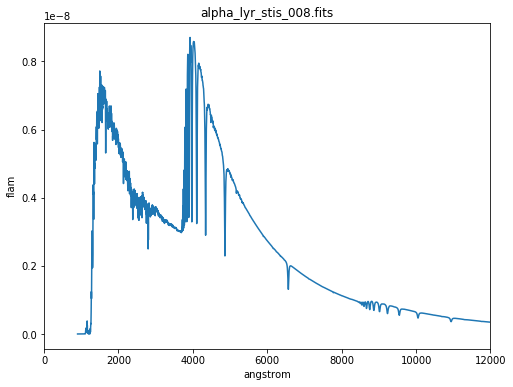

In [79]:
vega_spec = S.FileSpectrum(os.path.join(os.environ['PYSYN_CDBS'], 
                                        'calspec', 'alpha_lyr_stis_008.fits'))

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(vega_spec.wave, vega_spec.flux)
ax1.set_xlim(0, 12000)
ax1.set_xlabel(vega_spec.waveunits)
ax1.set_ylabel(vega_spec.fluxunits)
ax1.set_title(os.path.basename(vega_spec.name))

fig.show;

Notice how we used the `waveunits` and `fluxunits` attributes of the `vega_spec` object. The default flux units are "flam," which corresponds to ergs/s/cm<sup>2</sup>/Å.

### Exercise 1: Plotting a Spectrum

Add a new code cell below and make a plot similar to the one above using a different target spectrum. Include axis labels, units, and a title. Plot the flux in units of Jy and the wavelength in units of nanometers. *Hint:* Use the `psynphot` function `convert()`.

### Using Analytic Spectra

As previously mentioned, `pysynphot` also allows for the use of analytically defined spectra. Here we show how to create a composite spectrum out of a blackbody and powerlaw component:

In [80]:
bb_spec = S.BlackBody(10000)
pl_spec = S.PowerLaw(8000, -2)
composite_spec = bb_spec + pl_spec

### Manipulating Spectra

`pysynphot` has tools to redshift, add extinction to, and renormalize spectra. Note that the redshift transformation only shifts the spectrum in wavelength; it does not change the flux (this can be accomplished by redshifting in combination with the `renorm()` method). The extinction tool provides numerous options for the extinction law used with the default being the Milky Way extinction (R<sub>V</sub> = 3.1).

Here, we show how to add extinction with E(B – V) = 0.2 using the Milky Way extinction law to our blackbody spectrum (`bb_spec`) defined above, and plot both the original and extincted spectra for comparison:

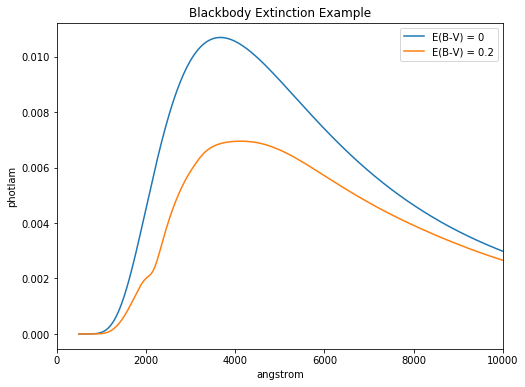

In [81]:
bb_spec_ebv02 = bb_spec * S.Extinction(0.1, 'mwavg')

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(bb_spec.wave, bb_spec.flux, label='E(B-V) = 0')
ax1.plot(bb_spec_ebv02.wave, bb_spec_ebv02.flux, label='E(B-V) = 0.2')
ax1.legend()
ax1.set_xlim(0, 10000)
ax1.set_xlabel(bb_spec.waveunits)
ax1.set_ylabel(bb_spec.fluxunits)
ax1.set_title('Blackbody Extinction Example')

fig.show;

Notice how the extinction was applied by multiplying the original spectrum object with a new `Extinction` object. The other manipulation tools in `pysynphot` are methods on the spectrum object, e.g., `composite_spec.redshift()`. Notice that the flux units are now given as "photlam," which corresponds to photons/s/cm<sup>2</sup>/Å. Here we have specified the 'mwavg' extinction law, however this is the default and we have only included to show the syntax.

## Creating a Bandpass

One of the most useful utilities of `pysynphot` for functional work is creating bandpasses by convolving sensitivity information for the various parts of the optical path. The observation mode ("obsmode") parameter defines the bandpass and is given as a string of keyword arguments (e.g., instrument, detector, filter) identifying the light path. For example, to calculate the bandpass of filter F218W using chip 1 of WFC3/UVIS:

In [82]:
bp_f218w = S.ObsBandpass('wfc3,uvis1,f218w')
bp_f218w_r04 = S.ObsBandpass('wfc3,uvis1,f218w,aper#0.4')

Here the 'aper#0.4' part of the string indicates that a circular aperture with radius 0.4 arcseconds should be used. The [obsmode keywords](https://pysynphot.readthedocs.io/en/latest/appendixb.html) appendix of the `pysynphot` documentation describes all of the *HST* instrument-specific keywords. `pysynphot` also includes several other well known filters such as the Johnson-Cousins _UBVRI_ and SDSS _ugriz_. **NOTE**: Many of the *HST* instruments include a time-dependent component to their sensitivity, which must be explicitly stated using 'mjd#' otherwise you will not get the correct result.

The `ObsBandpass` object can be plotted similarly to the spectrum object, but uses the `.throughput` rather than `.flux` attribute. Note that the throughput values are unitless. Here we show how to plot the throughput of the WFC3/UVIS1 F218W filter:

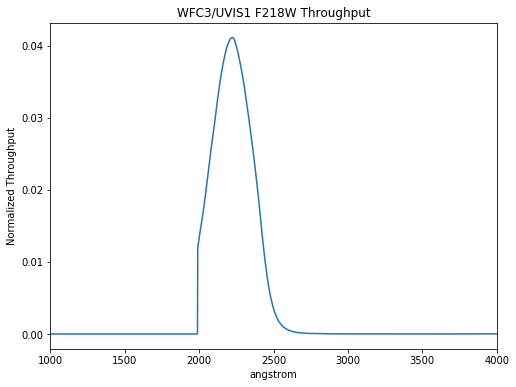

In [83]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(bp_f218w.wave, bp_f218w.throughput)
ax1.set_xlim(1000, 4000)
ax1.set_xlabel(bp_f218w.waveunits)
ax1.set_ylabel('Normalized Throughput')
ax1.set_title('WFC3/UVIS1 F218W Throughput')

fig.show;

In some cases, you may also be interested in the the throughput of a specific component along the optical path. This information can be extracted from the appropriate FITS table file, e.g.:

In [84]:
ota_bp = S.FileBandpass(os.path.join(os.environ['PYSYN_CDBS'], 'comp', 'ota',
                                    'hst_ota_007_syn.fits'))

### Exercise 2: Plotting an Obsmode

Add a new code cell below and plot a bandpass using a different obsmode. Feel free to use whichever instrument/detector/filter you like. Also plot comparable non-*HST* filter (e.g., ACS/WFC F606W and Johnson *V*). Include axis labels, units, a title, and a legend. Consult the [obsmode keyword](https://pysynphot.readthedocs.io/en/latest/appendixb.html) documentation for more information about obsmode options. *Hint:* It may be helpful to normalize the throughput curves.

## Creating Observations

Another extremely useful capability of `pysynphot` is creating synthetic photometry by modeling an observation of a source spectrum by convolving it with a bandpass. Creating an observation is simple:

In [85]:
vega_f218w = S.Observation(vega_spec, bp_f218w)

Note that the spectrum and the bandpass must overlap in wavelength space or an error will be raised. `pysynphot` does provide tools to force the spectrum to overlap with the bandpass via padding or extrapolation. The resulting observation object has several methods for computing the synthetic photometry:

In [86]:
vega_countrate = vega_f218w.countrate()
vega_jy = vega_f218w.effstim('Jy')

print('Vega WFC3/UVIS1 F218W: {} (counts/second)'.format(vega_countrate))
print('Vega WFC3/UVIS1 F218W: {} (Jy)'.format(vega_jy))

Vega WFC3/UVIS1 F218W: 321544461.7038386 (counts/second)
Vega WFC3/UVIS1 F218W: 770.3191024478152 (Jy)


Here the `countrate()` method returns the number of "counts" per second emitted by the source convoled with the bandpass and integrated over all wavelengths. Note that for most instruments, "counts" equates to photoelectrons, while for some older *HST* instruments it means DN. The `countrate()` method is also integrated over the *HST* primary mirror area. The `effstim()` method allows one perform synthetic photometry using requested units (e.g., "Jy" and "flam").

Observation objects, like spectra and bandpasses, can also be plotted using their wavelength and flux information:

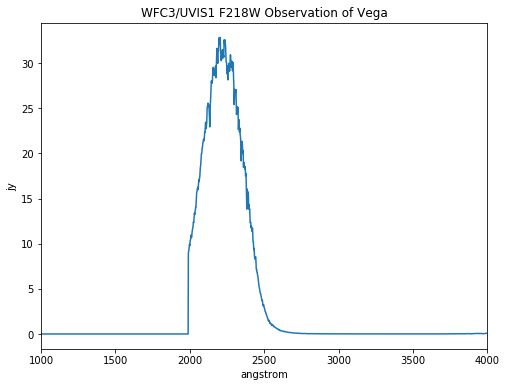

In [88]:
vega_f218w.convert('Jy')

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(vega_f218w.wave, vega_f218w.flux)
ax1.set_xlim(1000, 4000)
ax1.set_xlabel(vega_f218w.waveunits)
ax1.set_ylabel(vega_f218w.fluxunits)
ax1.set_title('WFC3/UVIS1 F218W Observation of Vega')

fig.show;

### Exercise 3: Observing a Spectrum

Add a new code cell below and, using the spectrum you defined in Exercise 1 and the bandpass you defined in Exercise 2, create an observation. Plot the resulting observed spectrum as seen through your bandpass, and also print the synthetic photometry in erg/s/cm<sup>2</sup>/Å, ST magnitude, AB magnitude, and Vega magnitude. *Hint:* See the `pysynphot` [flux units](https://pysynphot.readthedocs.io/en/latest/units.html#pysynphot-flux-units) documentation.

# HST Conclusion

Congratulations! This concludes both the general and *HST*-specific parts of the `PySynphot` training. Users who are working on *JWST* or are generally interested may continue on to the next part of the tutorial below. Some additional `pysynphot` functionality is demonstrated in the *JWST* examples.

If you are finished with the exercises, please email your updated version of this notebook to your trainer for evaluation.

# Using `PySynphot` for JWST

In the examples below we will use some functions from the packages `poppy` ("Physical Optics Propagation in PYthon") and `webbpsf` (*JWST* PSF Simulation Tool) with `pysynphot`. These packages are not packaged with AstroConda and must be installed separately. 

Before proceeding, you may wish to clone your astroconda environment as some packages (e.g., `numpy`) may be downgraded to work with these tools. To do this, in a bash shell type:
```
conda create --name jwstconda --clone astroconda
```
where we have cloned the conda environment named "astroconda" into a new one named "jwstconda." Switch to this new environment and install `poppy` and `webbpsf` by typing in a bash shell:
```
conda install poppy
conda install webbpsf
```

**NOTE**: If you did change conda environments, you will need to re-launch the notebook server in the new environment.

In [ ]:
import pysynphot as S
import numpy as np
import poppy
import webbpsf